In [3]:
from preprocessing import *
from train_evaluate import *
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np

# Data Setup

## Load Data

In [4]:
data_dir = '/Users/michael/Desktop/Home/研究所/ECE247/projects/data/'
X_train_valid, y_train_valid, X_test, y_test = load_data(data_dir, subjects=[1]) # default subjects=[1,2,3,4,5,6,7,8,9]

## Preprocessing

In [5]:
x_train, y_train, x_valid, y_valid, x_test, y_test = main_prep(X_train_valid,y_train_valid,X_test, y_test,2,2,True)

Shape of x_train: (758, 250, 1, 22)
Shape of x_valid: (190, 250, 1, 22)
Shape of x_test: (200, 250, 1, 22)
Shape of y_train: torch.Size([758, 4])
Shape of y_valid: torch.Size([190, 4])
Shape of y_test: torch.Size([200, 4])


## PyTorch Dataloaders

In [6]:
data_loaders  = dataloader_setup(x_train, y_train, x_valid, y_valid, x_test, y_test, batch_size=32)

## Parameters

In [7]:
LR      = 0.0005
BETAS   = (0.9, 0.999)
EPS     = 1e-08
DECAY   = 0.0005

BATCH_SIZE = 32
EPOCHS  = 100

# Modeling (CNN, LSTM, GRU, CNN+LSTM, CNN+GRU)

## Models

In [8]:
# # Building the CNN model using sequential class
class CNN(nn.Module):
    # initializers
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(22, 25, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool1 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn1 = nn.BatchNorm2d(25)
        self.dropout = nn.Dropout2d(p=0.5)

        self.conv2 = nn.Conv2d(25, 50, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool2 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn2 = nn.BatchNorm2d(50)

        self.conv3 = nn.Conv2d(50, 100, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool3 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn3 = nn.BatchNorm2d(100)

        self.conv4 = nn.Conv2d(100, 200, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool4 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn4 = nn.BatchNorm2d(200)
        
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(800,4)
        
    # forward method
    def forward(self, input):  #input(22,250,1)
        x = input.permute(0,1,3,2)
        x = self.dropout(self.bn1(self.pool1(F.elu(self.conv1(x)))))
        x = self.dropout(self.bn2(self.pool2(F.elu(self.conv2(x)))))
        x = self.dropout(self.bn3(self.pool3(F.elu(self.conv3(x)))))
        x = self.dropout(self.bn4(self.pool4(F.elu(self.conv4(x)))))
        x = self.flatten(x)
        out = self.dense(x) 
        return out
    
class LSTM(nn.Module):
    
    def __init__(self):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(22, 64, 3, batch_first=True, dropout=0.4)

        self.fc = nn.Sequential(
            nn.Linear(64, 54),
            nn.BatchNorm1d(num_features=54, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.4),
            nn.Linear(54, 44),
            nn.BatchNorm1d(num_features=44, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(44, 4)
        )
    
    def forward(self, x, h=None):

        # LSTM
        N, C, H, W = x.size()
        x = x.view(N, C, W).permute(0, 2, 1)
        out, _ = self.lstm(x)

        # Fully Connected Layer
        out = self.fc(out[:, -1, :])

        return out

class GRU(nn.Module):
    
    def __init__(self):
        super(GRU, self).__init__()

        self.gru = nn.GRU(22, 64, 3, batch_first=True, dropout=0.4)

        self.fc = nn.Sequential(
            nn.Linear(64, 54),
            nn.BatchNorm1d(num_features=54, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.4),
            nn.Linear(54, 44),
            nn.BatchNorm1d(num_features=44, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(44, 4)
        )
    
    def forward(self, x, h=None):

        # GRU
        N, C, H, W = x.size()
        x = x.view(N, C, W).permute(0, 2, 1)
        out, _ = self.gru(x)

        # Fully Connected Layer
        out = self.fc(out[:, -1, :])

        return out
    
class Permute(nn.Module):
    def forward(self, x):
        return x.permute(0, 2, 1, 3)
    
class CNN_LSTM(nn.Module):
    
    def __init__(self):
        super(CNN_LSTM, self).__init__()

        self.conv1 = nn.Conv2d(22, 25, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool1 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn1 = nn.BatchNorm2d(25)
        self.dropout = nn.Dropout2d(p=0.5)

        self.conv2 = nn.Conv2d(25, 50, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool2 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn2 = nn.BatchNorm2d(50)

        self.conv3 = nn.Conv2d(50, 100, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool3 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn3 = nn.BatchNorm2d(100)

        self.conv4 = nn.Conv2d(100, 200, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool4 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn4 = nn.BatchNorm2d(200)
        
        
        
        self.lstm = nn.LSTM(4, 64, 3, batch_first=True, dropout=0.4)
        
        self.fc = nn.Sequential(
            nn.Linear(64, 54),
            nn.BatchNorm1d(num_features=54, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.4),
            nn.Linear(54, 44),
            nn.BatchNorm1d(num_features=44, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(44, 4)
        )
    
    def forward(self, x):
        
        # CNN
        x = x.permute(0,1,3,2)
        x = self.dropout(self.bn1(self.pool1(F.elu(self.conv1(x)))))
        x = self.dropout(self.bn2(self.pool2(F.elu(self.conv2(x)))))
        x = self.dropout(self.bn3(self.pool3(F.elu(self.conv3(x)))))
        x = self.dropout(self.bn4(self.pool4(F.elu(self.conv4(x)))))

        # LSTM
        N, C, H, W = x.size()
        x = x.view(N, C, H).permute(0, 1, 2)
        out, _ = self.lstm(x)

        # Fully Connected Layer
        out = self.fc(out[:, -1, :])

        return out
    
class CNN_GRU(nn.Module):
    def __init__(self):
        super(CNN_GRU, self).__init__()

        self.conv1 = nn.Conv2d(22, 25, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool1 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn1 = nn.BatchNorm2d(25)
        self.dropout = nn.Dropout2d(p=0.5)

        self.conv2 = nn.Conv2d(25, 50, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool2 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn2 = nn.BatchNorm2d(50)

        self.conv3 = nn.Conv2d(50, 100, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool3 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn3 = nn.BatchNorm2d(100)

        self.conv4 = nn.Conv2d(100, 200, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool4 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn4 = nn.BatchNorm2d(200)
        
        self.gru = nn.GRU(4, 64, 3, batch_first=True, dropout=0.4)
        
        self.fc = nn.Sequential(
            nn.Linear(64, 54),
            nn.BatchNorm1d(num_features=54, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.4),
            nn.Linear(54, 44),
            nn.BatchNorm1d(num_features=44, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(44, 4)
        )
    
    def forward(self, x):

        # CNN
        x = x.permute(0,1,3,2)
        x = self.dropout(self.bn1(self.pool1(F.elu(self.conv1(x)))))
        x = self.dropout(self.bn2(self.pool2(F.elu(self.conv2(x)))))
        x = self.dropout(self.bn3(self.pool3(F.elu(self.conv3(x)))))
        x = self.dropout(self.bn4(self.pool4(F.elu(self.conv4(x)))))

        # GRU
        N, C, H, W = x.size()
        x = x.view(N, C, H).permute(0, 1, 2)
        out, _ = self.gru(x)

        # Fully Connected Layer
        out = self.fc(out[:, -1, :])

        return out

## Initiate models

In [9]:
# initiate CNN model
cnn = CNN()
# create your cnn optimizer
cnn_optimizer = optim.Adam(cnn.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=DECAY)

# initiate LSTM model
lstm = LSTM()
# create your lstm optimizer
lstm_optimizer = optim.Adam(lstm.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=DECAY)

# initiate GRU model
gru = GRU()
# create your gru optimizer
gru_optimizer = optim.Adam(gru.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=DECAY)

# initiate CNN_LSTM model
cnn_lstm = CNN_LSTM()
# create your cnn_lstm optimizer
cnn_lstm_optimizer = optim.Adam(cnn_lstm.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=DECAY)

# initiate CNN_GRU model
cnn_gru = CNN_GRU()
# create your cnn_gru optimizer
cnn_gru_optimizer = optim.Adam(cnn_gru.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=DECAY)

## CNN

Training Progress: 	Epoch 1 [0/758 (0.00%)]		Loss: 1.68144
Training Progress: 	Epoch 1 [320/758 (41.67%)]		Loss: 1.60377
Training Progress: 	Epoch 1 [640/758 (83.33%)]		Loss: 1.43851
	Train loss: 0.03675, Accuracy: 385/758 (50.00%)
	Validation loss: 0.00643, Accuracy: 82/190 (43.00%)
	Test loss: 0.00624, Accuracy: 89/200 (44.00%)

Training Progress: 	Epoch 2 [0/758 (0.00%)]		Loss: 1.45557
Training Progress: 	Epoch 2 [320/758 (41.67%)]		Loss: 1.55882
Training Progress: 	Epoch 2 [640/758 (83.33%)]		Loss: 1.23054
	Train loss: 0.03408, Accuracy: 408/758 (53.00%)
	Validation loss: 0.00632, Accuracy: 89/190 (46.00%)
	Test loss: 0.00620, Accuracy: 83/200 (41.00%)

Training Progress: 	Epoch 3 [0/758 (0.00%)]		Loss: 1.43445
Training Progress: 	Epoch 3 [320/758 (41.67%)]		Loss: 0.99409
Training Progress: 	Epoch 3 [640/758 (83.33%)]		Loss: 1.36191
	Train loss: 0.03222, Accuracy: 427/758 (56.00%)
	Validation loss: 0.00598, Accuracy: 101/190 (53.00%)
	Test loss: 0.00632, Accuracy: 97/200 (48.00%)



Training Progress: 	Epoch 25 [640/758 (83.33%)]		Loss: 0.63431
	Train loss: 0.00185, Accuracy: 753/758 (99.00%)
	Validation loss: 0.00067, Accuracy: 184/190 (96.00%)
	Test loss: 0.00550, Accuracy: 130/200 (65.00%)

Training Progress: 	Epoch 26 [0/758 (0.00%)]		Loss: 0.35333
Training Progress: 	Epoch 26 [320/758 (41.67%)]		Loss: 0.14094
Training Progress: 	Epoch 26 [640/758 (83.33%)]		Loss: 0.23871
	Train loss: 0.00156, Accuracy: 756/758 (99.00%)
	Validation loss: 0.00059, Accuracy: 185/190 (97.00%)
	Test loss: 0.00564, Accuracy: 133/200 (66.00%)

Training Progress: 	Epoch 27 [0/758 (0.00%)]		Loss: 0.14328
Training Progress: 	Epoch 27 [320/758 (41.67%)]		Loss: 0.23433
Training Progress: 	Epoch 27 [640/758 (83.33%)]		Loss: 0.37558
	Train loss: 0.00156, Accuracy: 755/758 (99.00%)
	Validation loss: 0.00060, Accuracy: 185/190 (97.00%)
	Test loss: 0.00519, Accuracy: 139/200 (69.00%)

Training Progress: 	Epoch 28 [0/758 (0.00%)]		Loss: 0.31571
Training Progress: 	Epoch 28 [320/758 (41.67%)]		

	Train loss: 0.00011, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00009, Accuracy: 190/190 (100.00%)
	Test loss: 0.00669, Accuracy: 130/200 (65.00%)

Training Progress: 	Epoch 50 [0/758 (0.00%)]		Loss: 0.09797
Training Progress: 	Epoch 50 [320/758 (41.67%)]		Loss: 0.12840
Training Progress: 	Epoch 50 [640/758 (83.33%)]		Loss: 0.19707
	Train loss: 0.00009, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00004, Accuracy: 190/190 (100.00%)
	Test loss: 0.00584, Accuracy: 131/200 (65.00%)

Training Progress: 	Epoch 51 [0/758 (0.00%)]		Loss: 0.31155
Training Progress: 	Epoch 51 [320/758 (41.67%)]		Loss: 0.27656
Training Progress: 	Epoch 51 [640/758 (83.33%)]		Loss: 0.08731
	Train loss: 0.00007, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00004, Accuracy: 190/190 (100.00%)
	Test loss: 0.00661, Accuracy: 137/200 (68.00%)

Training Progress: 	Epoch 52 [0/758 (0.00%)]		Loss: 0.03544
Training Progress: 	Epoch 52 [320/758 (41.67%)]		Loss: 0.08225
Training Progress: 	Epoch 52 [640/758 (83.3

	Test loss: 0.00740, Accuracy: 138/200 (69.00%)

Training Progress: 	Epoch 74 [0/758 (0.00%)]		Loss: 0.08968
Training Progress: 	Epoch 74 [320/758 (41.67%)]		Loss: 0.02781
Training Progress: 	Epoch 74 [640/758 (83.33%)]		Loss: 0.05906
	Train loss: 0.00002, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00001, Accuracy: 190/190 (100.00%)
	Test loss: 0.00713, Accuracy: 131/200 (65.00%)

Training Progress: 	Epoch 75 [0/758 (0.00%)]		Loss: 0.22951
Training Progress: 	Epoch 75 [320/758 (41.67%)]		Loss: 0.06326
Training Progress: 	Epoch 75 [640/758 (83.33%)]		Loss: 0.02946
	Train loss: 0.00003, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00001, Accuracy: 190/190 (100.00%)
	Test loss: 0.00737, Accuracy: 132/200 (66.00%)

Training Progress: 	Epoch 76 [0/758 (0.00%)]		Loss: 0.04154
Training Progress: 	Epoch 76 [320/758 (41.67%)]		Loss: 0.09839
Training Progress: 	Epoch 76 [640/758 (83.33%)]		Loss: 0.08848
	Train loss: 0.00002, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00001, Accuracy

Training Progress: 	Epoch 98 [320/758 (41.67%)]		Loss: 0.01362
Training Progress: 	Epoch 98 [640/758 (83.33%)]		Loss: 0.02000
	Train loss: 0.00001, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00001, Accuracy: 190/190 (100.00%)
	Test loss: 0.00700, Accuracy: 140/200 (70.00%)

Training Progress: 	Epoch 99 [0/758 (0.00%)]		Loss: 0.03002
Training Progress: 	Epoch 99 [320/758 (41.67%)]		Loss: 0.00579
Training Progress: 	Epoch 99 [640/758 (83.33%)]		Loss: 0.09641
	Train loss: 0.00001, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00000, Accuracy: 190/190 (100.00%)
	Test loss: 0.00653, Accuracy: 146/200 (73.00%)

Training Progress: 	Epoch 100 [0/758 (0.00%)]		Loss: 0.02840
Training Progress: 	Epoch 100 [320/758 (41.67%)]		Loss: 0.01500
Training Progress: 	Epoch 100 [640/758 (83.33%)]		Loss: 0.02212
	Train loss: 0.00001, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00001, Accuracy: 190/190 (100.00%)
	Test loss: 0.00731, Accuracy: 144/200 (72.00%)

Best validation accuracy:
1.0
Best te

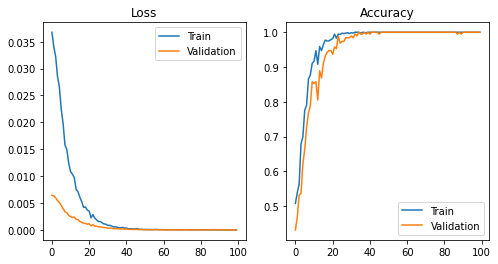

In [ ]:
train_and_evaluate(cnn, cnn_optimizer, data_loaders, num_epochs=EPOCHS)

## LSTM

Training Progress: 	Epoch 1 [0/758 (0.00%)]		Loss: 1.39611
Training Progress: 	Epoch 1 [320/758 (41.67%)]		Loss: 1.45574
Training Progress: 	Epoch 1 [640/758 (83.33%)]		Loss: 1.38174
	Train loss: 0.04390, Accuracy: 207/758 (27.00%)
	Validation loss: 0.00737, Accuracy: 52/190 (27.00%)
	Test loss: 0.00706, Accuracy: 48/200 (24.00%)

Training Progress: 	Epoch 2 [0/758 (0.00%)]		Loss: 1.41473
Training Progress: 	Epoch 2 [320/758 (41.67%)]		Loss: 1.40813
Training Progress: 	Epoch 2 [640/758 (83.33%)]		Loss: 1.41388
	Train loss: 0.04123, Accuracy: 312/758 (41.00%)
	Validation loss: 0.00717, Accuracy: 64/190 (33.00%)
	Test loss: 0.00702, Accuracy: 43/200 (21.00%)

Training Progress: 	Epoch 3 [0/758 (0.00%)]		Loss: 1.29013
Training Progress: 	Epoch 3 [320/758 (41.67%)]		Loss: 1.33394
Training Progress: 	Epoch 3 [640/758 (83.33%)]		Loss: 1.31862
	Train loss: 0.03980, Accuracy: 362/758 (47.00%)
	Validation loss: 0.00706, Accuracy: 72/190 (37.00%)
	Test loss: 0.00705, Accuracy: 46/200 (23.00%)

T

	Train loss: 0.00818, Accuracy: 714/758 (94.00%)
	Validation loss: 0.00269, Accuracy: 156/190 (82.00%)
	Test loss: 0.01068, Accuracy: 53/200 (26.00%)

Training Progress: 	Epoch 26 [0/758 (0.00%)]		Loss: 0.39423
Training Progress: 	Epoch 26 [320/758 (41.67%)]		Loss: 0.37482
Training Progress: 	Epoch 26 [640/758 (83.33%)]		Loss: 0.21092
	Train loss: 0.00507, Accuracy: 724/758 (95.00%)
	Validation loss: 0.00218, Accuracy: 163/190 (85.00%)
	Test loss: 0.01152, Accuracy: 57/200 (28.00%)

Training Progress: 	Epoch 27 [0/758 (0.00%)]		Loss: 0.21117
Training Progress: 	Epoch 27 [320/758 (41.67%)]		Loss: 0.22141
Training Progress: 	Epoch 27 [640/758 (83.33%)]		Loss: 0.15006
	Train loss: 0.00498, Accuracy: 728/758 (96.00%)
	Validation loss: 0.00250, Accuracy: 162/190 (85.00%)
	Test loss: 0.01130, Accuracy: 52/200 (26.00%)

Training Progress: 	Epoch 28 [0/758 (0.00%)]		Loss: 0.25946
Training Progress: 	Epoch 28 [320/758 (41.67%)]		Loss: 0.31199
Training Progress: 	Epoch 28 [640/758 (83.33%)]		Los

Training Progress: 	Epoch 50 [0/758 (0.00%)]		Loss: 0.10503
Training Progress: 	Epoch 50 [320/758 (41.67%)]		Loss: 0.03746
Training Progress: 	Epoch 50 [640/758 (83.33%)]		Loss: 0.10574
	Train loss: 0.00126, Accuracy: 751/758 (99.00%)
	Validation loss: 0.00170, Accuracy: 172/190 (90.00%)
	Test loss: 0.01365, Accuracy: 65/200 (32.00%)

Training Progress: 	Epoch 51 [0/758 (0.00%)]		Loss: 0.13467
Training Progress: 	Epoch 51 [320/758 (41.67%)]		Loss: 0.14490
Training Progress: 	Epoch 51 [640/758 (83.33%)]		Loss: 0.11926
	Train loss: 0.00151, Accuracy: 746/758 (98.00%)
	Validation loss: 0.00138, Accuracy: 175/190 (92.00%)
	Test loss: 0.01421, Accuracy: 65/200 (32.00%)

Training Progress: 	Epoch 52 [0/758 (0.00%)]		Loss: 0.18957
Training Progress: 	Epoch 52 [320/758 (41.67%)]		Loss: 0.08117
Training Progress: 	Epoch 52 [640/758 (83.33%)]		Loss: 0.15728
	Train loss: 0.00035, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00101, Accuracy: 180/190 (94.00%)
	Test loss: 0.01400, Accuracy: 68/20

Training Progress: 	Epoch 74 [640/758 (83.33%)]		Loss: 0.02081
	Train loss: 0.00029, Accuracy: 756/758 (99.00%)
	Validation loss: 0.00150, Accuracy: 175/190 (92.00%)
	Test loss: 0.01630, Accuracy: 66/200 (33.00%)

Training Progress: 	Epoch 75 [0/758 (0.00%)]		Loss: 0.07863
Training Progress: 	Epoch 75 [320/758 (41.67%)]		Loss: 0.01107
Training Progress: 	Epoch 75 [640/758 (83.33%)]		Loss: 0.01394
	Train loss: 0.00032, Accuracy: 756/758 (99.00%)
	Validation loss: 0.00125, Accuracy: 177/190 (93.00%)
	Test loss: 0.01600, Accuracy: 70/200 (35.00%)

Training Progress: 	Epoch 76 [0/758 (0.00%)]		Loss: 0.04614
Training Progress: 	Epoch 76 [320/758 (41.67%)]		Loss: 0.00993
Training Progress: 	Epoch 76 [640/758 (83.33%)]		Loss: 0.02043
	Train loss: 0.00018, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00136, Accuracy: 176/190 (92.00%)
	Test loss: 0.01633, Accuracy: 58/200 (29.00%)

Training Progress: 	Epoch 77 [0/758 (0.00%)]		Loss: 0.06706
Training Progress: 	Epoch 77 [320/758 (41.67%)]		Lo

	Validation loss: 0.00114, Accuracy: 181/190 (95.00%)
	Test loss: 0.01671, Accuracy: 69/200 (34.00%)

Training Progress: 	Epoch 99 [0/758 (0.00%)]		Loss: 0.01559
Training Progress: 	Epoch 99 [320/758 (41.67%)]		Loss: 0.01455
Training Progress: 	Epoch 99 [640/758 (83.33%)]		Loss: 0.00813
	Train loss: 0.00054, Accuracy: 753/758 (99.00%)
	Validation loss: 0.00148, Accuracy: 178/190 (93.00%)
	Test loss: 0.01655, Accuracy: 69/200 (34.00%)

Training Progress: 	Epoch 100 [0/758 (0.00%)]		Loss: 0.37918
Training Progress: 	Epoch 100 [320/758 (41.67%)]		Loss: 0.08505
Training Progress: 	Epoch 100 [640/758 (83.33%)]		Loss: 0.04100
	Train loss: 0.00025, Accuracy: 756/758 (99.00%)
	Validation loss: 0.00147, Accuracy: 178/190 (93.00%)
	Test loss: 0.01780, Accuracy: 60/200 (30.00%)

Best validation accuracy:
0.9631578947368421
Best test accuracy:
0.395


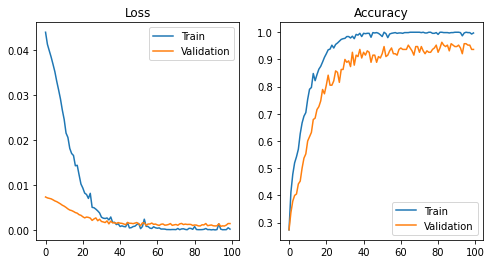

In [ ]:
train_and_evaluate(lstm, lstm_optimizer, data_loaders, num_epochs=EPOCHS)

## GRU

Training Progress: 	Epoch 1 [0/758 (0.00%)]		Loss: 1.45513
Training Progress: 	Epoch 1 [320/758 (41.67%)]		Loss: 1.45325
Training Progress: 	Epoch 1 [640/758 (83.33%)]		Loss: 1.38381
	Train loss: 0.04229, Accuracy: 247/758 (32.00%)
	Validation loss: 0.00721, Accuracy: 55/190 (28.00%)
	Test loss: 0.00679, Accuracy: 67/200 (33.00%)

Training Progress: 	Epoch 2 [0/758 (0.00%)]		Loss: 1.38469
Training Progress: 	Epoch 2 [320/758 (41.67%)]		Loss: 1.34475
Training Progress: 	Epoch 2 [640/758 (83.33%)]		Loss: 1.41266
	Train loss: 0.04107, Accuracy: 286/758 (37.00%)
	Validation loss: 0.00706, Accuracy: 63/190 (33.00%)
	Test loss: 0.00680, Accuracy: 65/200 (32.00%)

Training Progress: 	Epoch 3 [0/758 (0.00%)]		Loss: 1.34406
Training Progress: 	Epoch 3 [320/758 (41.67%)]		Loss: 1.22943
Training Progress: 	Epoch 3 [640/758 (83.33%)]		Loss: 1.42019
	Train loss: 0.04005, Accuracy: 332/758 (43.00%)
	Validation loss: 0.00697, Accuracy: 73/190 (38.00%)
	Test loss: 0.00671, Accuracy: 73/200 (36.00%)

T

	Train loss: 0.00745, Accuracy: 711/758 (93.00%)
	Validation loss: 0.00294, Accuracy: 154/190 (81.00%)
	Test loss: 0.01072, Accuracy: 56/200 (28.00%)

Training Progress: 	Epoch 26 [0/758 (0.00%)]		Loss: 0.47570
Training Progress: 	Epoch 26 [320/758 (41.67%)]		Loss: 0.35055
Training Progress: 	Epoch 26 [640/758 (83.33%)]		Loss: 0.31219
	Train loss: 0.00668, Accuracy: 712/758 (93.00%)
	Validation loss: 0.00282, Accuracy: 151/190 (79.00%)
	Test loss: 0.01039, Accuracy: 66/200 (33.00%)

Training Progress: 	Epoch 27 [0/758 (0.00%)]		Loss: 0.61952
Training Progress: 	Epoch 27 [320/758 (41.67%)]		Loss: 0.25527
Training Progress: 	Epoch 27 [640/758 (83.33%)]		Loss: 0.27582
	Train loss: 0.00548, Accuracy: 723/758 (95.00%)
	Validation loss: 0.00240, Accuracy: 163/190 (85.00%)
	Test loss: 0.01063, Accuracy: 64/200 (32.00%)

Training Progress: 	Epoch 28 [0/758 (0.00%)]		Loss: 0.54303
Training Progress: 	Epoch 28 [320/758 (41.67%)]		Loss: 0.30471
Training Progress: 	Epoch 28 [640/758 (83.33%)]		Los

Training Progress: 	Epoch 50 [0/758 (0.00%)]		Loss: 0.14429
Training Progress: 	Epoch 50 [320/758 (41.67%)]		Loss: 0.10182
Training Progress: 	Epoch 50 [640/758 (83.33%)]		Loss: 0.18626
	Train loss: 0.00083, Accuracy: 755/758 (99.00%)
	Validation loss: 0.00173, Accuracy: 174/190 (91.00%)
	Test loss: 0.01543, Accuracy: 54/200 (27.00%)

Training Progress: 	Epoch 51 [0/758 (0.00%)]		Loss: 0.25713
Training Progress: 	Epoch 51 [320/758 (41.67%)]		Loss: 0.19985
Training Progress: 	Epoch 51 [640/758 (83.33%)]		Loss: 0.04703
	Train loss: 0.00095, Accuracy: 753/758 (99.00%)
	Validation loss: 0.00187, Accuracy: 173/190 (91.00%)
	Test loss: 0.01392, Accuracy: 64/200 (32.00%)

Training Progress: 	Epoch 52 [0/758 (0.00%)]		Loss: 0.18570
Training Progress: 	Epoch 52 [320/758 (41.67%)]		Loss: 0.18519
Training Progress: 	Epoch 52 [640/758 (83.33%)]		Loss: 0.12269
	Train loss: 0.00075, Accuracy: 754/758 (99.00%)
	Validation loss: 0.00208, Accuracy: 171/190 (90.00%)
	Test loss: 0.01534, Accuracy: 60/200

Training Progress: 	Epoch 74 [640/758 (83.33%)]		Loss: 0.05211
	Train loss: 0.00024, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00151, Accuracy: 177/190 (93.00%)
	Test loss: 0.01675, Accuracy: 61/200 (30.00%)

Training Progress: 	Epoch 75 [0/758 (0.00%)]		Loss: 0.22175
Training Progress: 	Epoch 75 [320/758 (41.67%)]		Loss: 0.05802
Training Progress: 	Epoch 75 [640/758 (83.33%)]		Loss: 0.02351
	Train loss: 0.00024, Accuracy: 757/758 (99.00%)
	Validation loss: 0.00159, Accuracy: 179/190 (94.00%)
	Test loss: 0.01776, Accuracy: 55/200 (27.00%)

Training Progress: 	Epoch 76 [0/758 (0.00%)]		Loss: 0.05065
Training Progress: 	Epoch 76 [320/758 (41.67%)]		Loss: 0.05975
Training Progress: 	Epoch 76 [640/758 (83.33%)]		Loss: 0.03520
	Train loss: 0.00061, Accuracy: 754/758 (99.00%)
	Validation loss: 0.00209, Accuracy: 174/190 (91.00%)
	Test loss: 0.01880, Accuracy: 49/200 (24.00%)

Training Progress: 	Epoch 77 [0/758 (0.00%)]		Loss: 0.17704
Training Progress: 	Epoch 77 [320/758 (41.67%)]		Lo

	Validation loss: 0.00178, Accuracy: 179/190 (94.00%)
	Test loss: 0.01761, Accuracy: 58/200 (29.00%)

Training Progress: 	Epoch 99 [0/758 (0.00%)]		Loss: 0.08734
Training Progress: 	Epoch 99 [320/758 (41.67%)]		Loss: 0.04158
Training Progress: 	Epoch 99 [640/758 (83.33%)]		Loss: 0.03720
	Train loss: 0.00007, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00147, Accuracy: 180/190 (94.00%)
	Test loss: 0.01860, Accuracy: 54/200 (27.00%)

Training Progress: 	Epoch 100 [0/758 (0.00%)]		Loss: 0.03135
Training Progress: 	Epoch 100 [320/758 (41.67%)]		Loss: 0.37708
Training Progress: 	Epoch 100 [640/758 (83.33%)]		Loss: 0.01823
	Train loss: 0.00034, Accuracy: 755/758 (99.00%)
	Validation loss: 0.00195, Accuracy: 174/190 (91.00%)
	Test loss: 0.02030, Accuracy: 49/200 (24.00%)

Best validation accuracy:
0.9473684210526315
Best test accuracy:
0.395


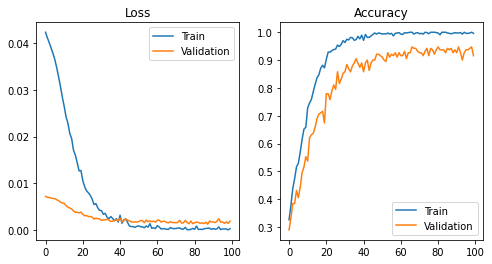

In [ ]:
train_and_evaluate(gru, gru_optimizer, data_loaders, num_epochs=EPOCHS)

## CNN+LSTM

Training Progress: 	Epoch 1 [0/758 (0.00%)]		Loss: 1.40390
Training Progress: 	Epoch 1 [320/758 (41.67%)]		Loss: 1.44890
Training Progress: 	Epoch 1 [640/758 (83.33%)]		Loss: 1.35888
	Train loss: 0.04414, Accuracy: 194/758 (25.00%)
	Validation loss: 0.00737, Accuracy: 46/190 (24.00%)
	Test loss: 0.00696, Accuracy: 48/200 (24.00%)

Training Progress: 	Epoch 2 [0/758 (0.00%)]		Loss: 1.41054
Training Progress: 	Epoch 2 [320/758 (41.67%)]		Loss: 1.43168
Training Progress: 	Epoch 2 [640/758 (83.33%)]		Loss: 1.36079
	Train loss: 0.04380, Accuracy: 221/758 (29.00%)
	Validation loss: 0.00730, Accuracy: 64/190 (33.00%)
	Test loss: 0.00688, Accuracy: 58/200 (29.00%)

Training Progress: 	Epoch 3 [0/758 (0.00%)]		Loss: 1.37558
Training Progress: 	Epoch 3 [320/758 (41.67%)]		Loss: 1.36231
Training Progress: 	Epoch 3 [640/758 (83.33%)]		Loss: 1.42403
	Train loss: 0.04360, Accuracy: 195/758 (25.00%)
	Validation loss: 0.00725, Accuracy: 49/190 (25.00%)
	Test loss: 0.00691, Accuracy: 48/200 (24.00%)

T

	Train loss: 0.01761, Accuracy: 561/758 (74.00%)
	Validation loss: 0.00319, Accuracy: 134/190 (70.00%)
	Test loss: 0.00541, Accuracy: 98/200 (49.00%)

Training Progress: 	Epoch 26 [0/758 (0.00%)]		Loss: 0.87037
Training Progress: 	Epoch 26 [320/758 (41.67%)]		Loss: 0.62103
Training Progress: 	Epoch 26 [640/758 (83.33%)]		Loss: 0.62090
	Train loss: 0.01661, Accuracy: 574/758 (75.00%)
	Validation loss: 0.00293, Accuracy: 140/190 (73.00%)
	Test loss: 0.00534, Accuracy: 102/200 (51.00%)

Training Progress: 	Epoch 27 [0/758 (0.00%)]		Loss: 0.88588
Training Progress: 	Epoch 27 [320/758 (41.67%)]		Loss: 0.72363
Training Progress: 	Epoch 27 [640/758 (83.33%)]		Loss: 0.61844
	Train loss: 0.01669, Accuracy: 581/758 (76.00%)
	Validation loss: 0.00297, Accuracy: 143/190 (75.00%)
	Test loss: 0.00533, Accuracy: 106/200 (53.00%)

Training Progress: 	Epoch 28 [0/758 (0.00%)]		Loss: 0.93021
Training Progress: 	Epoch 28 [320/758 (41.67%)]		Loss: 0.60977
Training Progress: 	Epoch 28 [640/758 (83.33%)]		L

	Test loss: 0.00709, Accuracy: 119/200 (59.00%)

Training Progress: 	Epoch 50 [0/758 (0.00%)]		Loss: 0.68465
Training Progress: 	Epoch 50 [320/758 (41.67%)]		Loss: 0.26777
Training Progress: 	Epoch 50 [640/758 (83.33%)]		Loss: 0.26904
	Train loss: 0.00307, Accuracy: 743/758 (98.00%)
	Validation loss: 0.00072, Accuracy: 183/190 (96.00%)
	Test loss: 0.00696, Accuracy: 117/200 (58.00%)

Training Progress: 	Epoch 51 [0/758 (0.00%)]		Loss: 0.47921
Training Progress: 	Epoch 51 [320/758 (41.67%)]		Loss: 0.26323
Training Progress: 	Epoch 51 [640/758 (83.33%)]		Loss: 0.32051
	Train loss: 0.00313, Accuracy: 745/758 (98.00%)
	Validation loss: 0.00078, Accuracy: 184/190 (96.00%)
	Test loss: 0.00680, Accuracy: 118/200 (59.00%)

Training Progress: 	Epoch 52 [0/758 (0.00%)]		Loss: 0.53389
Training Progress: 	Epoch 52 [320/758 (41.67%)]		Loss: 0.43357
Training Progress: 	Epoch 52 [640/758 (83.33%)]		Loss: 0.36392
	Train loss: 0.00400, Accuracy: 726/758 (95.00%)
	Validation loss: 0.00113, Accuracy: 175

Training Progress: 	Epoch 74 [320/758 (41.67%)]		Loss: 0.15429
Training Progress: 	Epoch 74 [640/758 (83.33%)]		Loss: 0.28787
	Train loss: 0.00139, Accuracy: 749/758 (98.00%)
	Validation loss: 0.00072, Accuracy: 182/190 (95.00%)
	Test loss: 0.00778, Accuracy: 123/200 (61.00%)

Training Progress: 	Epoch 75 [0/758 (0.00%)]		Loss: 0.73123
Training Progress: 	Epoch 75 [320/758 (41.67%)]		Loss: 0.29053
Training Progress: 	Epoch 75 [640/758 (83.33%)]		Loss: 0.45457
	Train loss: 0.00127, Accuracy: 753/758 (99.00%)
	Validation loss: 0.00027, Accuracy: 189/190 (99.00%)
	Test loss: 0.00685, Accuracy: 119/200 (59.00%)

Training Progress: 	Epoch 76 [0/758 (0.00%)]		Loss: 0.40612
Training Progress: 	Epoch 76 [320/758 (41.67%)]		Loss: 0.29687
Training Progress: 	Epoch 76 [640/758 (83.33%)]		Loss: 0.14211
	Train loss: 0.00136, Accuracy: 750/758 (98.00%)
	Validation loss: 0.00046, Accuracy: 182/190 (95.00%)
	Test loss: 0.00712, Accuracy: 128/200 (64.00%)

Training Progress: 	Epoch 77 [0/758 (0.00%)]		

	Train loss: 0.00023, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00025, Accuracy: 187/190 (98.00%)
	Test loss: 0.00848, Accuracy: 128/200 (64.00%)

Training Progress: 	Epoch 99 [0/758 (0.00%)]		Loss: 0.16147
Training Progress: 	Epoch 99 [320/758 (41.67%)]		Loss: 0.16346
Training Progress: 	Epoch 99 [640/758 (83.33%)]		Loss: 0.11691
	Train loss: 0.00035, Accuracy: 757/758 (99.00%)
	Validation loss: 0.00011, Accuracy: 189/190 (99.00%)
	Test loss: 0.00795, Accuracy: 129/200 (64.00%)

Training Progress: 	Epoch 100 [0/758 (0.00%)]		Loss: 0.26806
Training Progress: 	Epoch 100 [320/758 (41.67%)]		Loss: 0.04576
Training Progress: 	Epoch 100 [640/758 (83.33%)]		Loss: 0.36130
	Train loss: 0.00028, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00050, Accuracy: 187/190 (98.00%)
	Test loss: 0.00813, Accuracy: 132/200 (66.00%)

Best validation accuracy:
1.0
Best test accuracy:
0.66


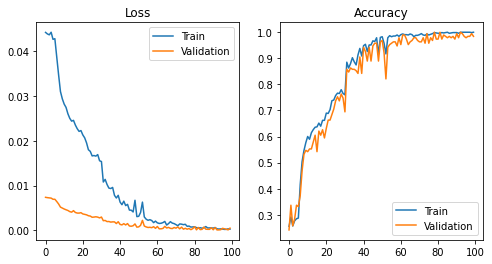

In [ ]:
train_and_evaluate(cnn_lstm, cnn_lstm_optimizer, data_loaders, num_epochs=EPOCHS)

## CNN+GRU

Training Progress: 	Epoch 1 [0/758 (0.00%)]		Loss: 1.60243
Training Progress: 	Epoch 1 [320/758 (41.67%)]		Loss: 1.40011
Training Progress: 	Epoch 1 [640/758 (83.33%)]		Loss: 1.33687
	Train loss: 0.04386, Accuracy: 187/758 (24.00%)
	Validation loss: 0.00721, Accuracy: 48/190 (25.00%)
	Test loss: 0.00697, Accuracy: 48/200 (24.00%)

Training Progress: 	Epoch 2 [0/758 (0.00%)]		Loss: 1.43163
Training Progress: 	Epoch 2 [320/758 (41.67%)]		Loss: 1.32607
Training Progress: 	Epoch 2 [640/758 (83.33%)]		Loss: 1.36693
	Train loss: 0.04745, Accuracy: 206/758 (27.00%)
	Validation loss: 0.00772, Accuracy: 60/190 (31.00%)
	Test loss: 0.00760, Accuracy: 61/200 (30.00%)

Training Progress: 	Epoch 3 [0/758 (0.00%)]		Loss: 1.44807
Training Progress: 	Epoch 3 [320/758 (41.67%)]		Loss: 1.32493
Training Progress: 	Epoch 3 [640/758 (83.33%)]		Loss: 1.28819
	Train loss: 0.04646, Accuracy: 208/758 (27.00%)
	Validation loss: 0.00759, Accuracy: 58/190 (30.00%)
	Test loss: 0.00745, Accuracy: 45/200 (22.00%)

T

	Train loss: 0.01872, Accuracy: 545/758 (71.00%)
	Validation loss: 0.00370, Accuracy: 121/190 (63.00%)
	Test loss: 0.00537, Accuracy: 96/200 (48.00%)

Training Progress: 	Epoch 26 [0/758 (0.00%)]		Loss: 0.87164
Training Progress: 	Epoch 26 [320/758 (41.67%)]		Loss: 0.67305
Training Progress: 	Epoch 26 [640/758 (83.33%)]		Loss: 0.56046
	Train loss: 0.01763, Accuracy: 556/758 (73.00%)
	Validation loss: 0.00321, Accuracy: 132/190 (69.00%)
	Test loss: 0.00541, Accuracy: 97/200 (48.00%)

Training Progress: 	Epoch 27 [0/758 (0.00%)]		Loss: 0.85488
Training Progress: 	Epoch 27 [320/758 (41.67%)]		Loss: 0.58650
Training Progress: 	Epoch 27 [640/758 (83.33%)]		Loss: 0.57167
	Train loss: 0.01819, Accuracy: 548/758 (72.00%)
	Validation loss: 0.00346, Accuracy: 126/190 (66.00%)
	Test loss: 0.00541, Accuracy: 103/200 (51.00%)

Training Progress: 	Epoch 28 [0/758 (0.00%)]		Loss: 0.79995
Training Progress: 	Epoch 28 [320/758 (41.67%)]		Loss: 0.62215
Training Progress: 	Epoch 28 [640/758 (83.33%)]		Lo

	Test loss: 0.00588, Accuracy: 122/200 (61.00%)

Training Progress: 	Epoch 50 [0/758 (0.00%)]		Loss: 0.51860
Training Progress: 	Epoch 50 [320/758 (41.67%)]		Loss: 0.43049
Training Progress: 	Epoch 50 [640/758 (83.33%)]		Loss: 0.40547
	Train loss: 0.00884, Accuracy: 671/758 (88.00%)
	Validation loss: 0.00194, Accuracy: 158/190 (83.00%)
	Test loss: 0.00609, Accuracy: 118/200 (59.00%)

Training Progress: 	Epoch 51 [0/758 (0.00%)]		Loss: 0.56737
Training Progress: 	Epoch 51 [320/758 (41.67%)]		Loss: 0.48663
Training Progress: 	Epoch 51 [640/758 (83.33%)]		Loss: 0.59913
	Train loss: 0.00759, Accuracy: 691/758 (91.00%)
	Validation loss: 0.00158, Accuracy: 162/190 (85.00%)
	Test loss: 0.00578, Accuracy: 121/200 (60.00%)

Training Progress: 	Epoch 52 [0/758 (0.00%)]		Loss: 0.55840
Training Progress: 	Epoch 52 [320/758 (41.67%)]		Loss: 0.44194
Training Progress: 	Epoch 52 [640/758 (83.33%)]		Loss: 0.58025
	Train loss: 0.00603, Accuracy: 712/758 (93.00%)
	Validation loss: 0.00142, Accuracy: 169

Training Progress: 	Epoch 74 [320/758 (41.67%)]		Loss: 0.29809
Training Progress: 	Epoch 74 [640/758 (83.33%)]		Loss: 0.42145
	Train loss: 0.00182, Accuracy: 749/758 (98.00%)
	Validation loss: 0.00079, Accuracy: 179/190 (94.00%)
	Test loss: 0.00638, Accuracy: 129/200 (64.00%)

Training Progress: 	Epoch 75 [0/758 (0.00%)]		Loss: 0.30917
Training Progress: 	Epoch 75 [320/758 (41.67%)]		Loss: 0.19594
Training Progress: 	Epoch 75 [640/758 (83.33%)]		Loss: 0.31359
	Train loss: 0.00131, Accuracy: 755/758 (99.00%)
	Validation loss: 0.00043, Accuracy: 186/190 (97.00%)
	Test loss: 0.00677, Accuracy: 132/200 (66.00%)

Training Progress: 	Epoch 76 [0/758 (0.00%)]		Loss: 0.40180
Training Progress: 	Epoch 76 [320/758 (41.67%)]		Loss: 0.24624
Training Progress: 	Epoch 76 [640/758 (83.33%)]		Loss: 0.30389
	Train loss: 0.00113, Accuracy: 755/758 (99.00%)
	Validation loss: 0.00032, Accuracy: 188/190 (98.00%)
	Test loss: 0.00610, Accuracy: 135/200 (67.00%)

Training Progress: 	Epoch 77 [0/758 (0.00%)]		

	Train loss: 0.00057, Accuracy: 755/758 (99.00%)
	Validation loss: 0.00018, Accuracy: 188/190 (98.00%)
	Test loss: 0.00744, Accuracy: 128/200 (64.00%)

Training Progress: 	Epoch 99 [0/758 (0.00%)]		Loss: 0.13495
Training Progress: 	Epoch 99 [320/758 (41.67%)]		Loss: 0.06861
Training Progress: 	Epoch 99 [640/758 (83.33%)]		Loss: 0.14218
	Train loss: 0.00032, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00016, Accuracy: 188/190 (98.00%)
	Test loss: 0.00735, Accuracy: 134/200 (67.00%)

Training Progress: 	Epoch 100 [0/758 (0.00%)]		Loss: 0.18617
Training Progress: 	Epoch 100 [320/758 (41.67%)]		Loss: 0.20481
Training Progress: 	Epoch 100 [640/758 (83.33%)]		Loss: 0.08274
	Train loss: 0.00029, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00011, Accuracy: 189/190 (99.00%)
	Test loss: 0.00741, Accuracy: 133/200 (66.00%)

Best validation accuracy:
0.9947368421052631
Best test accuracy:
0.71


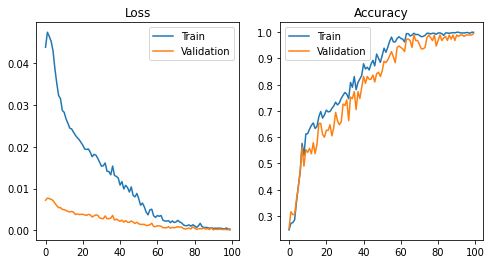

In [ ]:
train_and_evaluate(cnn_gru, cnn_gru_optimizer, data_loaders, num_epochs=EPOCHS)

# GAN Data Augmentation

In [12]:
fake_WGAN = np.load('./GAN/WGAN_generate_X_subject1.npy')
fake_label = np.load('./GAN/generate_label_subject1.npy')


fake_WGAN = np.swapaxes(fake_WGAN, 1,2)
fake_WGAN = np.swapaxes(fake_WGAN,2,3)


#Add 8460/4 fake data
x_train_plus = np.vstack((x_train, fake_WGAN[0:fake_WGAN.shape[0]//4]))
y_train_plus = np.vstack((y_train, fake_label[0:fake_WGAN.shape[0]//4]))
p = np.random.permutation(x_train.shape[0])
x_train_plus, y_train_plus = x_train_plus[p], y_train_plus[p]

In [13]:
data_loaders_wgan = dataloader_setup(x_train_plus, y_train_plus, x_valid, y_valid, x_test, y_test, batch_size=32)

# WGAN

## CNN

Training Progress: 	Epoch 1 [0/758 (0.00%)]		Loss: 0.02660
Training Progress: 	Epoch 1 [320/758 (41.67%)]		Loss: 0.01101
Training Progress: 	Epoch 1 [640/758 (83.33%)]		Loss: 0.04643
	Train loss: 0.00001, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00068, Accuracy: 186/190 (97.00%)
	Test loss: 0.00721, Accuracy: 143/200 (71.00%)

Training Progress: 	Epoch 2 [0/758 (0.00%)]		Loss: 0.04333
Training Progress: 	Epoch 2 [320/758 (41.67%)]		Loss: 0.03582
Training Progress: 	Epoch 2 [640/758 (83.33%)]		Loss: 0.01849
	Train loss: 0.00001, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00084, Accuracy: 186/190 (97.00%)
	Test loss: 0.00790, Accuracy: 139/200 (69.00%)

Training Progress: 	Epoch 3 [0/758 (0.00%)]		Loss: 0.02067
Training Progress: 	Epoch 3 [320/758 (41.67%)]		Loss: 0.02258
Training Progress: 	Epoch 3 [640/758 (83.33%)]		Loss: 0.02843
	Train loss: 0.00000, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00067, Accuracy: 186/190 (97.00%)
	Test loss: 0.00803, Accuracy: 137/200 (6

Training Progress: 	Epoch 25 [640/758 (83.33%)]		Loss: 0.03677
	Train loss: 0.00000, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00054, Accuracy: 185/190 (97.00%)
	Test loss: 0.00792, Accuracy: 130/200 (65.00%)

Training Progress: 	Epoch 26 [0/758 (0.00%)]		Loss: 0.01643
Training Progress: 	Epoch 26 [320/758 (41.67%)]		Loss: 0.19265
Training Progress: 	Epoch 26 [640/758 (83.33%)]		Loss: 0.01113
	Train loss: 0.00000, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00070, Accuracy: 185/190 (97.00%)
	Test loss: 0.00765, Accuracy: 138/200 (69.00%)

Training Progress: 	Epoch 27 [0/758 (0.00%)]		Loss: 0.00725
Training Progress: 	Epoch 27 [320/758 (41.67%)]		Loss: 0.00371
Training Progress: 	Epoch 27 [640/758 (83.33%)]		Loss: 0.00155
	Train loss: 0.00000, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00061, Accuracy: 185/190 (97.00%)
	Test loss: 0.00822, Accuracy: 135/200 (67.00%)

Training Progress: 	Epoch 28 [0/758 (0.00%)]		Loss: 0.01944
Training Progress: 	Epoch 28 [320/758 (41.67%)

	Train loss: 0.00000, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00082, Accuracy: 186/190 (97.00%)
	Test loss: 0.00713, Accuracy: 139/200 (69.00%)

Training Progress: 	Epoch 50 [0/758 (0.00%)]		Loss: 0.00841
Training Progress: 	Epoch 50 [320/758 (41.67%)]		Loss: 0.00243
Training Progress: 	Epoch 50 [640/758 (83.33%)]		Loss: 0.03338
	Train loss: 0.00000, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00095, Accuracy: 186/190 (97.00%)
	Test loss: 0.00813, Accuracy: 135/200 (67.00%)

Training Progress: 	Epoch 51 [0/758 (0.00%)]		Loss: 0.00495
Training Progress: 	Epoch 51 [320/758 (41.67%)]		Loss: 0.01498
Training Progress: 	Epoch 51 [640/758 (83.33%)]		Loss: 0.05350
	Train loss: 0.00000, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00065, Accuracy: 186/190 (97.00%)
	Test loss: 0.00826, Accuracy: 135/200 (67.00%)

Training Progress: 	Epoch 52 [0/758 (0.00%)]		Loss: 0.17652
Training Progress: 	Epoch 52 [320/758 (41.67%)]		Loss: 0.02148
Training Progress: 	Epoch 52 [640/758 (83.33%)

	Test loss: 0.00831, Accuracy: 143/200 (71.00%)

Training Progress: 	Epoch 74 [0/758 (0.00%)]		Loss: 0.04168
Training Progress: 	Epoch 74 [320/758 (41.67%)]		Loss: 0.01723
Training Progress: 	Epoch 74 [640/758 (83.33%)]		Loss: 0.01294
	Train loss: 0.00000, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00082, Accuracy: 186/190 (97.00%)
	Test loss: 0.00864, Accuracy: 133/200 (66.00%)

Training Progress: 	Epoch 75 [0/758 (0.00%)]		Loss: 0.00179
Training Progress: 	Epoch 75 [320/758 (41.67%)]		Loss: 0.03309
Training Progress: 	Epoch 75 [640/758 (83.33%)]		Loss: 0.00549
	Train loss: 0.00000, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00076, Accuracy: 186/190 (97.00%)
	Test loss: 0.00816, Accuracy: 134/200 (67.00%)

Training Progress: 	Epoch 76 [0/758 (0.00%)]		Loss: 0.02658
Training Progress: 	Epoch 76 [320/758 (41.67%)]		Loss: 0.01405
Training Progress: 	Epoch 76 [640/758 (83.33%)]		Loss: 0.03471
	Train loss: 0.00000, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00074, Accuracy: 

Training Progress: 	Epoch 98 [320/758 (41.67%)]		Loss: 0.01672
Training Progress: 	Epoch 98 [640/758 (83.33%)]		Loss: 0.00258
	Train loss: 0.00000, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00083, Accuracy: 186/190 (97.00%)
	Test loss: 0.00888, Accuracy: 138/200 (69.00%)

Training Progress: 	Epoch 99 [0/758 (0.00%)]		Loss: 0.02217
Training Progress: 	Epoch 99 [320/758 (41.67%)]		Loss: 0.02570
Training Progress: 	Epoch 99 [640/758 (83.33%)]		Loss: 0.00259
	Train loss: 0.00000, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00074, Accuracy: 186/190 (97.00%)
	Test loss: 0.00874, Accuracy: 137/200 (68.00%)

Training Progress: 	Epoch 100 [0/758 (0.00%)]		Loss: 0.01792
Training Progress: 	Epoch 100 [320/758 (41.67%)]		Loss: 0.03372
Training Progress: 	Epoch 100 [640/758 (83.33%)]		Loss: 0.00174
	Train loss: 0.00000, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00081, Accuracy: 186/190 (97.00%)
	Test loss: 0.00914, Accuracy: 138/200 (69.00%)

Best validation accuracy:
0.978947368421

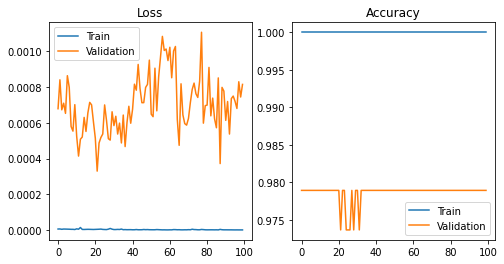

In [14]:
train_and_evaluate(cnn, cnn_optimizer, data_loaders_wgan, num_epochs=EPOCHS)

## LSTM

Training Progress: 	Epoch 1 [0/758 (0.00%)]		Loss: 1.40371
Training Progress: 	Epoch 1 [320/758 (41.67%)]		Loss: 1.46005
Training Progress: 	Epoch 1 [640/758 (83.33%)]		Loss: 1.30743
	Train loss: 0.04350, Accuracy: 218/758 (28.00%)
	Validation loss: 0.00725, Accuracy: 58/190 (30.00%)
	Test loss: 0.00688, Accuracy: 62/200 (31.00%)

Training Progress: 	Epoch 2 [0/758 (0.00%)]		Loss: 1.36400
Training Progress: 	Epoch 2 [320/758 (41.67%)]		Loss: 1.41351
Training Progress: 	Epoch 2 [640/758 (83.33%)]		Loss: 1.27950
	Train loss: 0.04103, Accuracy: 293/758 (38.00%)
	Validation loss: 0.00700, Accuracy: 68/190 (35.00%)
	Test loss: 0.00692, Accuracy: 64/200 (32.00%)

Training Progress: 	Epoch 3 [0/758 (0.00%)]		Loss: 1.30631
Training Progress: 	Epoch 3 [320/758 (41.67%)]		Loss: 1.34525
Training Progress: 	Epoch 3 [640/758 (83.33%)]		Loss: 1.23337
	Train loss: 0.03997, Accuracy: 336/758 (44.00%)
	Validation loss: 0.00690, Accuracy: 77/190 (40.00%)
	Test loss: 0.00688, Accuracy: 60/200 (30.00%)

T

	Train loss: 0.00406, Accuracy: 740/758 (97.00%)
	Validation loss: 0.00187, Accuracy: 164/190 (86.00%)
	Test loss: 0.01107, Accuracy: 66/200 (33.00%)

Training Progress: 	Epoch 26 [0/758 (0.00%)]		Loss: 0.26858
Training Progress: 	Epoch 26 [320/758 (41.67%)]		Loss: 0.21856
Training Progress: 	Epoch 26 [640/758 (83.33%)]		Loss: 0.23201
	Train loss: 0.00313, Accuracy: 746/758 (98.00%)
	Validation loss: 0.00151, Accuracy: 173/190 (91.00%)
	Test loss: 0.01162, Accuracy: 61/200 (30.00%)

Training Progress: 	Epoch 27 [0/758 (0.00%)]		Loss: 0.31900
Training Progress: 	Epoch 27 [320/758 (41.67%)]		Loss: 0.29952
Training Progress: 	Epoch 27 [640/758 (83.33%)]		Loss: 0.19037
	Train loss: 0.00299, Accuracy: 747/758 (98.00%)
	Validation loss: 0.00144, Accuracy: 172/190 (90.00%)
	Test loss: 0.01192, Accuracy: 63/200 (31.00%)

Training Progress: 	Epoch 28 [0/758 (0.00%)]		Loss: 0.25966
Training Progress: 	Epoch 28 [320/758 (41.67%)]		Loss: 0.24381
Training Progress: 	Epoch 28 [640/758 (83.33%)]		Los

	Test loss: 0.01614, Accuracy: 56/200 (28.00%)

Training Progress: 	Epoch 50 [0/758 (0.00%)]		Loss: 0.02602
Training Progress: 	Epoch 50 [320/758 (41.67%)]		Loss: 0.24355
Training Progress: 	Epoch 50 [640/758 (83.33%)]		Loss: 0.13730
	Train loss: 0.00047, Accuracy: 756/758 (99.00%)
	Validation loss: 0.00057, Accuracy: 180/190 (94.00%)
	Test loss: 0.01524, Accuracy: 64/200 (32.00%)

Training Progress: 	Epoch 51 [0/758 (0.00%)]		Loss: 0.11603
Training Progress: 	Epoch 51 [320/758 (41.67%)]		Loss: 0.03657
Training Progress: 	Epoch 51 [640/758 (83.33%)]		Loss: 0.04905
	Train loss: 0.00027, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00050, Accuracy: 184/190 (96.00%)
	Test loss: 0.01557, Accuracy: 63/200 (31.00%)

Training Progress: 	Epoch 52 [0/758 (0.00%)]		Loss: 0.03390
Training Progress: 	Epoch 52 [320/758 (41.67%)]		Loss: 0.06518
Training Progress: 	Epoch 52 [640/758 (83.33%)]		Loss: 0.12959
	Train loss: 0.00034, Accuracy: 756/758 (99.00%)
	Validation loss: 0.00051, Accuracy: 183/1

Training Progress: 	Epoch 74 [320/758 (41.67%)]		Loss: 0.02006
Training Progress: 	Epoch 74 [640/758 (83.33%)]		Loss: 0.05724
	Train loss: 0.00019, Accuracy: 757/758 (99.00%)
	Validation loss: 0.00036, Accuracy: 188/190 (98.00%)
	Test loss: 0.01692, Accuracy: 72/200 (36.00%)

Training Progress: 	Epoch 75 [0/758 (0.00%)]		Loss: 0.02072
Training Progress: 	Epoch 75 [320/758 (41.67%)]		Loss: 0.04825
Training Progress: 	Epoch 75 [640/758 (83.33%)]		Loss: 0.03987
	Train loss: 0.00103, Accuracy: 751/758 (99.00%)
	Validation loss: 0.00055, Accuracy: 186/190 (97.00%)
	Test loss: 0.01740, Accuracy: 59/200 (29.00%)

Training Progress: 	Epoch 76 [0/758 (0.00%)]		Loss: 0.09321
Training Progress: 	Epoch 76 [320/758 (41.67%)]		Loss: 0.21652
Training Progress: 	Epoch 76 [640/758 (83.33%)]		Loss: 0.02188
	Train loss: 0.00015, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00032, Accuracy: 185/190 (97.00%)
	Test loss: 0.01694, Accuracy: 67/200 (33.00%)

Training Progress: 	Epoch 77 [0/758 (0.00%)]		Lo

	Train loss: 0.00027, Accuracy: 757/758 (99.00%)
	Validation loss: 0.00033, Accuracy: 187/190 (98.00%)
	Test loss: 0.01912, Accuracy: 64/200 (32.00%)

Training Progress: 	Epoch 99 [0/758 (0.00%)]		Loss: 0.02436
Training Progress: 	Epoch 99 [320/758 (41.67%)]		Loss: 0.01609
Training Progress: 	Epoch 99 [640/758 (83.33%)]		Loss: 0.00815
	Train loss: 0.00004, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00005, Accuracy: 190/190 (100.00%)
	Test loss: 0.01923, Accuracy: 62/200 (31.00%)

Training Progress: 	Epoch 100 [0/758 (0.00%)]		Loss: 0.03087
Training Progress: 	Epoch 100 [320/758 (41.67%)]		Loss: 0.01151
Training Progress: 	Epoch 100 [640/758 (83.33%)]		Loss: 0.01562
	Train loss: 0.00004, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00011, Accuracy: 189/190 (99.00%)
	Test loss: 0.01822, Accuracy: 65/200 (32.00%)

Best validation accuracy:
1.0
Best test accuracy:
0.395


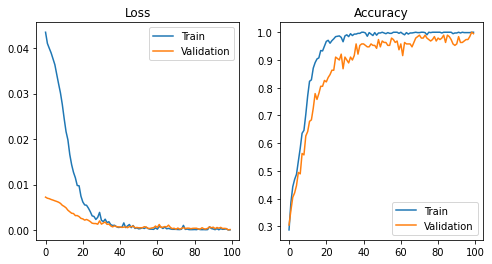

In [ ]:
train_and_evaluate(lstm, lstm_optimizer, data_loaders_wgan, num_epochs=EPOCHS)

## GRU

Training Progress: 	Epoch 1 [0/758 (0.00%)]		Loss: 1.66243
Training Progress: 	Epoch 1 [320/758 (41.67%)]		Loss: 1.38509
Training Progress: 	Epoch 1 [640/758 (83.33%)]		Loss: 1.38967
	Train loss: 0.04301, Accuracy: 214/758 (28.00%)
	Validation loss: 0.00721, Accuracy: 49/190 (25.00%)
	Test loss: 0.00704, Accuracy: 44/200 (22.00%)

Training Progress: 	Epoch 2 [0/758 (0.00%)]		Loss: 1.41188
Training Progress: 	Epoch 2 [320/758 (41.67%)]		Loss: 1.34148
Training Progress: 	Epoch 2 [640/758 (83.33%)]		Loss: 1.29236
	Train loss: 0.04162, Accuracy: 281/758 (37.00%)
	Validation loss: 0.00700, Accuracy: 70/190 (36.00%)
	Test loss: 0.00707, Accuracy: 50/200 (25.00%)

Training Progress: 	Epoch 3 [0/758 (0.00%)]		Loss: 1.32102
Training Progress: 	Epoch 3 [320/758 (41.67%)]		Loss: 1.27461
Training Progress: 	Epoch 3 [640/758 (83.33%)]		Loss: 1.30408
	Train loss: 0.04019, Accuracy: 356/758 (46.00%)
	Validation loss: 0.00687, Accuracy: 80/190 (42.00%)
	Test loss: 0.00707, Accuracy: 45/200 (22.00%)

T

	Train loss: 0.00676, Accuracy: 712/758 (93.00%)
	Validation loss: 0.00292, Accuracy: 143/190 (75.00%)
	Test loss: 0.00971, Accuracy: 64/200 (32.00%)

Training Progress: 	Epoch 26 [0/758 (0.00%)]		Loss: 0.30590
Training Progress: 	Epoch 26 [320/758 (41.67%)]		Loss: 0.28936
Training Progress: 	Epoch 26 [640/758 (83.33%)]		Loss: 0.46476
	Train loss: 0.00668, Accuracy: 716/758 (94.00%)
	Validation loss: 0.00278, Accuracy: 149/190 (78.00%)
	Test loss: 0.00946, Accuracy: 60/200 (30.00%)

Training Progress: 	Epoch 27 [0/758 (0.00%)]		Loss: 0.41745
Training Progress: 	Epoch 27 [320/758 (41.67%)]		Loss: 0.35239
Training Progress: 	Epoch 27 [640/758 (83.33%)]		Loss: 0.48414
	Train loss: 0.00578, Accuracy: 721/758 (95.00%)
	Validation loss: 0.00256, Accuracy: 149/190 (78.00%)
	Test loss: 0.00970, Accuracy: 67/200 (33.00%)

Training Progress: 	Epoch 28 [0/758 (0.00%)]		Loss: 0.35705
Training Progress: 	Epoch 28 [320/758 (41.67%)]		Loss: 0.46173
Training Progress: 	Epoch 28 [640/758 (83.33%)]		Los

Training Progress: 	Epoch 50 [0/758 (0.00%)]		Loss: 0.05564
Training Progress: 	Epoch 50 [320/758 (41.67%)]		Loss: 0.21343
Training Progress: 	Epoch 50 [640/758 (83.33%)]		Loss: 0.36839
	Train loss: 0.00068, Accuracy: 755/758 (99.00%)
	Validation loss: 0.00110, Accuracy: 177/190 (93.00%)
	Test loss: 0.01326, Accuracy: 69/200 (34.00%)

Training Progress: 	Epoch 51 [0/758 (0.00%)]		Loss: 0.04577
Training Progress: 	Epoch 51 [320/758 (41.67%)]		Loss: 0.09830
Training Progress: 	Epoch 51 [640/758 (83.33%)]		Loss: 0.16624
	Train loss: 0.00074, Accuracy: 755/758 (99.00%)
	Validation loss: 0.00118, Accuracy: 172/190 (90.00%)
	Test loss: 0.01260, Accuracy: 75/200 (37.00%)

Training Progress: 	Epoch 52 [0/758 (0.00%)]		Loss: 0.03866
Training Progress: 	Epoch 52 [320/758 (41.67%)]		Loss: 0.06417
Training Progress: 	Epoch 52 [640/758 (83.33%)]		Loss: 0.06123
	Train loss: 0.00050, Accuracy: 756/758 (99.00%)
	Validation loss: 0.00110, Accuracy: 176/190 (92.00%)
	Test loss: 0.01264, Accuracy: 78/200

Training Progress: 	Epoch 74 [640/758 (83.33%)]		Loss: 0.01778
	Train loss: 0.00028, Accuracy: 757/758 (99.00%)
	Validation loss: 0.00096, Accuracy: 177/190 (93.00%)
	Test loss: 0.01470, Accuracy: 73/200 (36.00%)

Training Progress: 	Epoch 75 [0/758 (0.00%)]		Loss: 0.03238
Training Progress: 	Epoch 75 [320/758 (41.67%)]		Loss: 0.03432
Training Progress: 	Epoch 75 [640/758 (83.33%)]		Loss: 0.02577
	Train loss: 0.00042, Accuracy: 755/758 (99.00%)
	Validation loss: 0.00130, Accuracy: 177/190 (93.00%)
	Test loss: 0.01597, Accuracy: 72/200 (36.00%)

Training Progress: 	Epoch 76 [0/758 (0.00%)]		Loss: 0.05406
Training Progress: 	Epoch 76 [320/758 (41.67%)]		Loss: 0.01580
Training Progress: 	Epoch 76 [640/758 (83.33%)]		Loss: 0.07212
	Train loss: 0.00014, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00115, Accuracy: 176/190 (92.00%)
	Test loss: 0.01598, Accuracy: 72/200 (36.00%)

Training Progress: 	Epoch 77 [0/758 (0.00%)]		Loss: 0.03584
Training Progress: 	Epoch 77 [320/758 (41.67%)]		Lo

	Validation loss: 0.00105, Accuracy: 175/190 (92.00%)
	Test loss: 0.01691, Accuracy: 59/200 (29.00%)

Training Progress: 	Epoch 99 [0/758 (0.00%)]		Loss: 0.04113
Training Progress: 	Epoch 99 [320/758 (41.67%)]		Loss: 0.02803
Training Progress: 	Epoch 99 [640/758 (83.33%)]		Loss: 0.07194
	Train loss: 0.00065, Accuracy: 754/758 (99.00%)
	Validation loss: 0.00124, Accuracy: 175/190 (92.00%)
	Test loss: 0.01764, Accuracy: 72/200 (36.00%)

Training Progress: 	Epoch 100 [0/758 (0.00%)]		Loss: 0.00468
Training Progress: 	Epoch 100 [320/758 (41.67%)]		Loss: 0.01116
Training Progress: 	Epoch 100 [640/758 (83.33%)]		Loss: 0.06630
	Train loss: 0.00013, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00071, Accuracy: 181/190 (95.00%)
	Test loss: 0.01571, Accuracy: 80/200 (40.00%)

Best validation accuracy:
0.9631578947368421
Best test accuracy:
0.42


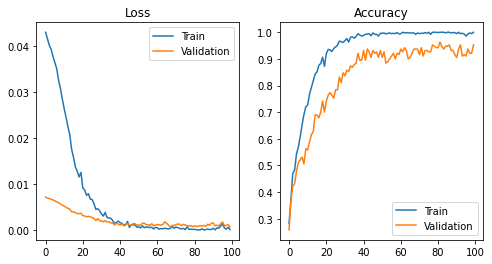

In [16]:
train_and_evaluate(gru, gru_optimizer, data_loaders_wgan, num_epochs=EPOCHS)

## CNN+LSTM

Training Progress: 	Epoch 1 [0/758 (0.00%)]		Loss: 1.44143
Training Progress: 	Epoch 1 [320/758 (41.67%)]		Loss: 1.47310
Training Progress: 	Epoch 1 [640/758 (83.33%)]		Loss: 1.47662
	Train loss: 0.04392, Accuracy: 183/758 (24.00%)
	Validation loss: 0.00730, Accuracy: 49/190 (25.00%)
	Test loss: 0.00693, Accuracy: 56/200 (28.00%)

Training Progress: 	Epoch 2 [0/758 (0.00%)]		Loss: 1.45030
Training Progress: 	Epoch 2 [320/758 (41.67%)]		Loss: 1.45954
Training Progress: 	Epoch 2 [640/758 (83.33%)]		Loss: 1.45790
	Train loss: 0.04388, Accuracy: 188/758 (24.00%)
	Validation loss: 0.00732, Accuracy: 49/190 (25.00%)
	Test loss: 0.00695, Accuracy: 49/200 (24.00%)

Training Progress: 	Epoch 3 [0/758 (0.00%)]		Loss: 1.49508
Training Progress: 	Epoch 3 [320/758 (41.67%)]		Loss: 1.37359
Training Progress: 	Epoch 3 [640/758 (83.33%)]		Loss: 1.43971
	Train loss: 0.04377, Accuracy: 197/758 (25.00%)
	Validation loss: 0.00733, Accuracy: 50/190 (26.00%)
	Test loss: 0.00700, Accuracy: 48/200 (24.00%)

T

	Train loss: 0.01669, Accuracy: 596/758 (78.00%)
	Validation loss: 0.00340, Accuracy: 132/190 (69.00%)
	Test loss: 0.00546, Accuracy: 108/200 (54.00%)

Training Progress: 	Epoch 26 [0/758 (0.00%)]		Loss: 0.64966
Training Progress: 	Epoch 26 [320/758 (41.67%)]		Loss: 0.60344
Training Progress: 	Epoch 26 [640/758 (83.33%)]		Loss: 0.86696
	Train loss: 0.01583, Accuracy: 620/758 (81.00%)
	Validation loss: 0.00355, Accuracy: 130/190 (68.00%)
	Test loss: 0.00551, Accuracy: 114/200 (57.00%)

Training Progress: 	Epoch 27 [0/758 (0.00%)]		Loss: 0.55581
Training Progress: 	Epoch 27 [320/758 (41.67%)]		Loss: 0.57786
Training Progress: 	Epoch 27 [640/758 (83.33%)]		Loss: 0.75260
	Train loss: 0.01532, Accuracy: 607/758 (80.00%)
	Validation loss: 0.00343, Accuracy: 133/190 (70.00%)
	Test loss: 0.00559, Accuracy: 118/200 (59.00%)

Training Progress: 	Epoch 28 [0/758 (0.00%)]		Loss: 0.66578
Training Progress: 	Epoch 28 [320/758 (41.67%)]		Loss: 0.45337
Training Progress: 	Epoch 28 [640/758 (83.33%)]		

	Test loss: 0.00599, Accuracy: 123/200 (61.00%)

Training Progress: 	Epoch 50 [0/758 (0.00%)]		Loss: 0.25632
Training Progress: 	Epoch 50 [320/758 (41.67%)]		Loss: 0.18824
Training Progress: 	Epoch 50 [640/758 (83.33%)]		Loss: 0.35523
	Train loss: 0.00289, Accuracy: 748/758 (98.00%)
	Validation loss: 0.00132, Accuracy: 174/190 (91.00%)
	Test loss: 0.00605, Accuracy: 122/200 (61.00%)

Training Progress: 	Epoch 51 [0/758 (0.00%)]		Loss: 0.49913
Training Progress: 	Epoch 51 [320/758 (41.67%)]		Loss: 0.21951
Training Progress: 	Epoch 51 [640/758 (83.33%)]		Loss: 0.41864
	Train loss: 0.00271, Accuracy: 742/758 (97.00%)
	Validation loss: 0.00130, Accuracy: 173/190 (91.00%)
	Test loss: 0.00692, Accuracy: 116/200 (58.00%)

Training Progress: 	Epoch 52 [0/758 (0.00%)]		Loss: 0.51784
Training Progress: 	Epoch 52 [320/758 (41.67%)]		Loss: 0.23592
Training Progress: 	Epoch 52 [640/758 (83.33%)]		Loss: 0.49764
	Train loss: 0.00303, Accuracy: 744/758 (98.00%)
	Validation loss: 0.00153, Accuracy: 171

Training Progress: 	Epoch 74 [320/758 (41.67%)]		Loss: 0.07157
Training Progress: 	Epoch 74 [640/758 (83.33%)]		Loss: 0.11775
	Train loss: 0.00116, Accuracy: 755/758 (99.00%)
	Validation loss: 0.00126, Accuracy: 177/190 (93.00%)
	Test loss: 0.00758, Accuracy: 115/200 (57.00%)

Training Progress: 	Epoch 75 [0/758 (0.00%)]		Loss: 0.12513
Training Progress: 	Epoch 75 [320/758 (41.67%)]		Loss: 0.50049
Training Progress: 	Epoch 75 [640/758 (83.33%)]		Loss: 0.11260
	Train loss: 0.00094, Accuracy: 755/758 (99.00%)
	Validation loss: 0.00131, Accuracy: 175/190 (92.00%)
	Test loss: 0.00666, Accuracy: 130/200 (65.00%)

Training Progress: 	Epoch 76 [0/758 (0.00%)]		Loss: 0.25575
Training Progress: 	Epoch 76 [320/758 (41.67%)]		Loss: 0.09439
Training Progress: 	Epoch 76 [640/758 (83.33%)]		Loss: 0.18651
	Train loss: 0.00094, Accuracy: 754/758 (99.00%)
	Validation loss: 0.00122, Accuracy: 174/190 (91.00%)
	Test loss: 0.00718, Accuracy: 124/200 (62.00%)

Training Progress: 	Epoch 77 [0/758 (0.00%)]		

	Train loss: 0.00073, Accuracy: 755/758 (99.00%)
	Validation loss: 0.00126, Accuracy: 177/190 (93.00%)
	Test loss: 0.00778, Accuracy: 125/200 (62.00%)

Training Progress: 	Epoch 99 [0/758 (0.00%)]		Loss: 0.16043
Training Progress: 	Epoch 99 [320/758 (41.67%)]		Loss: 0.19938
Training Progress: 	Epoch 99 [640/758 (83.33%)]		Loss: 0.23573
	Train loss: 0.00068, Accuracy: 755/758 (99.00%)
	Validation loss: 0.00147, Accuracy: 177/190 (93.00%)
	Test loss: 0.00753, Accuracy: 132/200 (66.00%)

Training Progress: 	Epoch 100 [0/758 (0.00%)]		Loss: 0.05041
Training Progress: 	Epoch 100 [320/758 (41.67%)]		Loss: 0.28625
Training Progress: 	Epoch 100 [640/758 (83.33%)]		Loss: 0.13325
	Train loss: 0.00049, Accuracy: 755/758 (99.00%)
	Validation loss: 0.00144, Accuracy: 174/190 (91.00%)
	Test loss: 0.00792, Accuracy: 131/200 (65.00%)

Best validation accuracy:
0.9421052631578948
Best test accuracy:
0.68


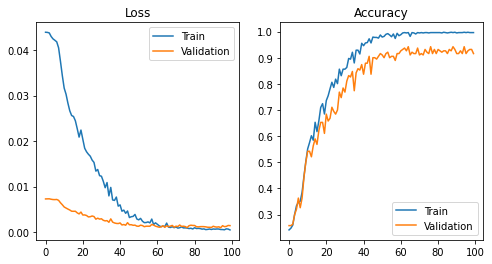

In [17]:
train_and_evaluate(cnn_lstm, cnn_lstm_optimizer, data_loaders_wgan, num_epochs=EPOCHS)

## CNN+GRU

Training Progress: 	Epoch 1 [0/758 (0.00%)]		Loss: 1.00039
Training Progress: 	Epoch 1 [320/758 (41.67%)]		Loss: 0.90635
Training Progress: 	Epoch 1 [640/758 (83.33%)]		Loss: 0.66885
	Train loss: 0.01497, Accuracy: 638/758 (84.00%)
	Validation loss: 0.00270, Accuracy: 161/190 (84.00%)
	Test loss: 0.00496, Accuracy: 102/200 (51.00%)

Training Progress: 	Epoch 2 [0/758 (0.00%)]		Loss: 0.68773
Training Progress: 	Epoch 2 [320/758 (41.67%)]		Loss: 0.74179
Training Progress: 	Epoch 2 [640/758 (83.33%)]		Loss: 0.30958
	Train loss: 0.00931, Accuracy: 664/758 (87.00%)
	Validation loss: 0.00206, Accuracy: 160/190 (84.00%)
	Test loss: 0.00558, Accuracy: 122/200 (61.00%)

Training Progress: 	Epoch 3 [0/758 (0.00%)]		Loss: 0.64851
Training Progress: 	Epoch 3 [320/758 (41.67%)]		Loss: 0.63303
Training Progress: 	Epoch 3 [640/758 (83.33%)]		Loss: 0.85261
	Train loss: 0.00760, Accuracy: 733/758 (96.00%)
	Validation loss: 0.00172, Accuracy: 175/190 (92.00%)
	Test loss: 0.00562, Accuracy: 104/200 (52.0

Training Progress: 	Epoch 25 [640/758 (83.33%)]		Loss: 0.07882
	Train loss: 0.00050, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00010, Accuracy: 190/190 (100.00%)
	Test loss: 0.00666, Accuracy: 118/200 (59.00%)

Training Progress: 	Epoch 26 [0/758 (0.00%)]		Loss: 0.45920
Training Progress: 	Epoch 26 [320/758 (41.67%)]		Loss: 0.06580
Training Progress: 	Epoch 26 [640/758 (83.33%)]		Loss: 0.13215
	Train loss: 0.00060, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00012, Accuracy: 190/190 (100.00%)
	Test loss: 0.00636, Accuracy: 124/200 (62.00%)

Training Progress: 	Epoch 27 [0/758 (0.00%)]		Loss: 0.25770
Training Progress: 	Epoch 27 [320/758 (41.67%)]		Loss: 0.19591
Training Progress: 	Epoch 27 [640/758 (83.33%)]		Loss: 0.03584
	Train loss: 0.00051, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00011, Accuracy: 190/190 (100.00%)
	Test loss: 0.00688, Accuracy: 119/200 (59.00%)

Training Progress: 	Epoch 28 [0/758 (0.00%)]		Loss: 0.11169
Training Progress: 	Epoch 28 [320/758 (41.6

	Train loss: 0.00015, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00003, Accuracy: 190/190 (100.00%)
	Test loss: 0.00856, Accuracy: 118/200 (59.00%)

Training Progress: 	Epoch 50 [0/758 (0.00%)]		Loss: 0.04172
Training Progress: 	Epoch 50 [320/758 (41.67%)]		Loss: 0.11332
Training Progress: 	Epoch 50 [640/758 (83.33%)]		Loss: 0.02867
	Train loss: 0.00015, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00003, Accuracy: 190/190 (100.00%)
	Test loss: 0.00840, Accuracy: 118/200 (59.00%)

Training Progress: 	Epoch 51 [0/758 (0.00%)]		Loss: 0.03192
Training Progress: 	Epoch 51 [320/758 (41.67%)]		Loss: 0.03541
Training Progress: 	Epoch 51 [640/758 (83.33%)]		Loss: 0.11635
	Train loss: 0.00018, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00005, Accuracy: 190/190 (100.00%)
	Test loss: 0.00677, Accuracy: 123/200 (61.00%)

Training Progress: 	Epoch 52 [0/758 (0.00%)]		Loss: 0.15146
Training Progress: 	Epoch 52 [320/758 (41.67%)]		Loss: 0.09684
Training Progress: 	Epoch 52 [640/758 (83.3

	Validation loss: 0.00002, Accuracy: 190/190 (100.00%)
	Test loss: 0.00790, Accuracy: 131/200 (65.00%)

Training Progress: 	Epoch 74 [0/758 (0.00%)]		Loss: 0.04984
Training Progress: 	Epoch 74 [320/758 (41.67%)]		Loss: 0.03504
Training Progress: 	Epoch 74 [640/758 (83.33%)]		Loss: 0.03895
	Train loss: 0.00007, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00002, Accuracy: 190/190 (100.00%)
	Test loss: 0.00782, Accuracy: 129/200 (64.00%)

Training Progress: 	Epoch 75 [0/758 (0.00%)]		Loss: 0.06982
Training Progress: 	Epoch 75 [320/758 (41.67%)]		Loss: 0.19814
Training Progress: 	Epoch 75 [640/758 (83.33%)]		Loss: 0.01324
	Train loss: 0.00009, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00002, Accuracy: 190/190 (100.00%)
	Test loss: 0.00864, Accuracy: 125/200 (62.00%)

Training Progress: 	Epoch 76 [0/758 (0.00%)]		Loss: 0.01986
Training Progress: 	Epoch 76 [320/758 (41.67%)]		Loss: 0.17995
Training Progress: 	Epoch 76 [640/758 (83.33%)]		Loss: 0.04002
	Train loss: 0.00008, Accuracy

	Test loss: 0.00981, Accuracy: 117/200 (58.00%)

Training Progress: 	Epoch 98 [0/758 (0.00%)]		Loss: 0.06555
Training Progress: 	Epoch 98 [320/758 (41.67%)]		Loss: 0.06013
Training Progress: 	Epoch 98 [640/758 (83.33%)]		Loss: 0.01001
	Train loss: 0.00015, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00003, Accuracy: 190/190 (100.00%)
	Test loss: 0.00887, Accuracy: 128/200 (64.00%)

Training Progress: 	Epoch 99 [0/758 (0.00%)]		Loss: 0.28761
Training Progress: 	Epoch 99 [320/758 (41.67%)]		Loss: 0.12536
Training Progress: 	Epoch 99 [640/758 (83.33%)]		Loss: 0.02404
	Train loss: 0.00006, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00001, Accuracy: 190/190 (100.00%)
	Test loss: 0.00823, Accuracy: 127/200 (63.00%)

Training Progress: 	Epoch 100 [0/758 (0.00%)]		Loss: 0.05094
Training Progress: 	Epoch 100 [320/758 (41.67%)]		Loss: 0.18798
Training Progress: 	Epoch 100 [640/758 (83.33%)]		Loss: 0.01773
	Train loss: 0.00006, Accuracy: 758/758 (100.00%)
	Validation loss: 0.00001, Accur

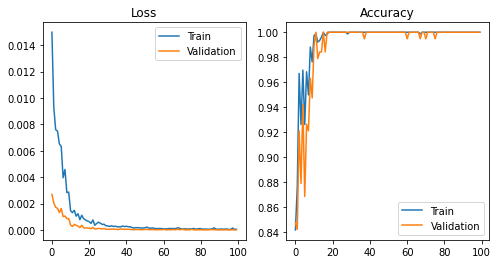

In [ ]:
train_and_evaluate(cnn_gru, cnn_gru_optimizer, data_loaders_wgan, num_epochs=EPOCHS)